Image if you will that I take quite a few photos, but don't manage them well. 

Mistakes may have been made. 

Like, i've discovered that when you ask apple photos "don't import duplicates" it's not competely foolproof. And if you in a fit of stupidity tried to recombine a google photos (re-compressed) library with your main library you end up with a bunch of duplicates. 

![A Horrible Decision, Really](https://media.giphy.com/media/u1edH5vUfg8xO/giphy.gif)

And I may have had various processing workflows over the years which stored the masters in a few different ways, and I might have, without a lot of thought, just thrown all the libraries together into a big mess. 

Anyway, I need to group a smallish (~10^4) photo library into groups of _identical_ photos where identical means that they look the same. Step 2 (not done yet) is to then choose the best and delete the rest.

We start with some functions for a processing chain:

Let's pull apart the file path - we might want this as metadata later on

In [1]:
def file_info(p):
    r = {}
    r['file path'] = p
    r['file name'] = p.name
    r['file posixpath'] = p.as_posix()
    r['file suffix'] = p.suffix
    r['file nameparts'] = p.name.split('-')
    return r

Then we want to be able to read an image. Any type of image, so let's go for PIL (or rather [Pillow](https://python-pillow.org). *Except* that we discover that my RAW images have more pixels than I realised and I end up with a letterbox image if we don't crop them using the available metadata. It turns out that [rawkit](https://github.com/photoshell/rawkit) is the better way to do this, so fall back to that for non-jpgs, and then go through a dance to convert them into PIL Images.

In [2]:
import tempfile, numpy as np, tempfile
from rawkit.raw import Raw
from PIL import Image

def read_raw(i):
    if i['file suffix'] == '.jpg': 
        i['image'] = Image.open(i['file path'])
    else: # PIL doesn't crop the RAW file correctly. adjust by not using PIL
          with Raw(filename=i['file posixpath']) as raw:
            im = np.array(raw.to_buffer())
            im = im.reshape((raw.metadata.width, raw.metadata.height, 3))
            i['image'] = Image.frombytes(
                'RGB', 
                (raw.metadata.width, raw.metadata.height),
                 im)
    i['size'] = i['image'].size
    return i

And let's generate a thumbnail for display purposes

In [3]:
def thumb(i):
    i['thumb'] = i['image'].resize((200,200), Image.ANTIALIAS)
    return i

And some utilities. 

In [4]:
def del_image(i):
    # just to save memory
    del(i['image'])
    return i

def print_dot(i):
    print('', end='.')
    return i

def thread(*args):
    """
    Supply a bunch of functions, and something to pipe through them. 
    Sort of like -> in clojure.
    """
    i = args[-1]
    for f in args[:-1]:
        try:
            i = f(i)
        except Exception as ex:
            print(ex)
            return None
    return i

%matplotlib inline
import matplotlib.pyplot as plt, math
from mpl_toolkits.axes_grid1 import ImageGrid
def print_index(grid):
    """
    Plot a grid of images. Given a list of lists, plot them.
    """
    width = max(len(n) for n in grid)
    fig = plt.figure()
    width_inches = 10.
    # we'd like the width to be about 5 inches. Adjust height accordingly
    # Each square will be width_inches/width inches. 
    # So height will be width_inches/width*len(grid)
    fig.set_size_inches(width_inches, (width_inches/width)*len(grid))
    plot = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(len(grid), width),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )
    i = -1
    for row in grid:
        for col in range(width):
            i += 1
            plot[i].axis('off')
            if col < len(row) and row[col] is not None: # we may have filled out lines.
                plot[i].imshow(row[col]['thumb'])
                plot[i].text(0, 20, row[col]['file name'])
                txt = row[col]['file suffix'] + str(row[col]['size'])
                plot[i].text(0, 50,txt)
    plt.show()

Now we get to the nub. How do we find similar images? Well, that's a research topic. I got really sidetracked here, because there's a lot of research on finding photos of the same thing from different viewpoints (also useful for object tracking). There's some fun work out there (like [google image search](https://www.quora.com/What-is-the-algorithm-used-by-Googles-reverse-image-search-i-e-search-by-image)
that does magic, but I'm after something simpler because this is not supposed to take all day. Now, we could do a big n\*n similarity matrix of all the images and search that. Again, lots of ideas about how to measure similarity between images ([here's a start](http://stackoverflow.com/questions/189943/how-can-i-quantify-difference-between-two-images), or [here](http://stackoverflow.com/questions/596262/image-fingerprint-to-compare-similarity-of-many-images), [here](http://stackoverflow.com/questions/1034900/near-duplicate-image-detection/))

But it seems overkill because I'm actually after ~exact matches (although possibly resized or recompressed, or even 'auto-adjusted'). 
 
What we really want is a hash of an image. Pick a set of attributes that don't change through some transformations, and use that as an index. This is [not a new idea](http://qanda.digipres.org/58/what-techniques-there-detecting-similar-images-large-scale)

So I first thought I would be smart and use SIFT to [find transformation-invariant parts of images](http://docs.opencv.org/3.2.0/dc/dc3/tutorial_py_matcher.html), and then use them as an index somehow, but it turns out that 

 * This is great for finding how 2 images may relate to each other, but is not so great for searching a large corpus for similar images. ([see here](http://stackoverflow.com/questions/2146542/opencv-surf-how-to-generate-a-image-hash-fingerprint-signature-out-of-the))
 * it's not neccessary
 
A simpler way is to run the image through a bunch of transformations that reduce the information while maintaining some idea of the perceptual similarity. Often people will try things like converting to greyscale, normalising, downsizing, taking some histograms, and somehow hashing them. There's a bunch of methods, and luckily for me there's a python library of them called [imagehash](https://github.com/JohannesBuchner/imagehash).

In [5]:
import imagehash
def image_hash(hfunc, i):
    i['hash'] = hfunc(i['image'])
    i['hashhash'] = hash(i['hash']) # Hash is an array. let's also take a hash of that
    return i

Now let's go and get the files.

In [6]:
import os, itertools, random
from pathlib import Path

#photo_masters = os.environ['HOME'] + '/Pictures/Photos Library.photoslibrary/Masters/'
photo_masters='./ph/test/'
masters_path = Path(photo_masters)
files = masters_path.rglob('*.*')
files = filter(lambda x: not x.is_dir(), files)
#files = filter(lambda x: random.random() <= 0.1, files)

and put them through the pipe.

In [7]:
import functools, imagehash
pipe = [file_info, 
        read_raw, 
        functools.partial(image_hash, imagehash.whash), 
        thumb, 
        del_image, 
        print_dot]
images = (thread(*pipe, f) for f in files)
# thread returns None if there's a failure for that file, so filter.
images = (i  for i in images if i is not None)

# collect them into a list so we can use it repetedly.
images = list(images)

....................

Let's see what we've got

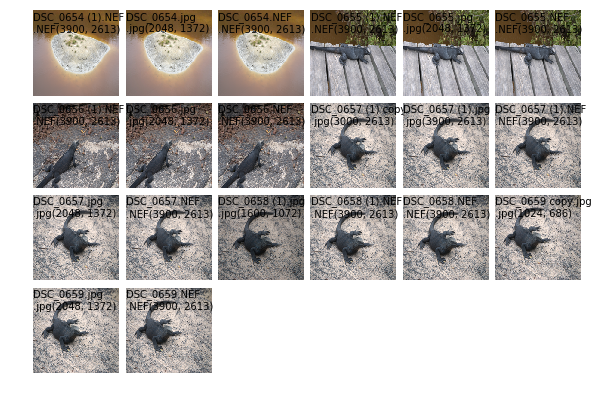

In [8]:
grid = list(itertools.zip_longest(*[iter(images)]*6))
print_index(grid)

And now collect the results into a hashtable with buckets of (hopefully) similar images.

In [9]:
from collections import defaultdict
indx = defaultdict(list)
for f in images:
    indx[f['hashhash']].append(f)

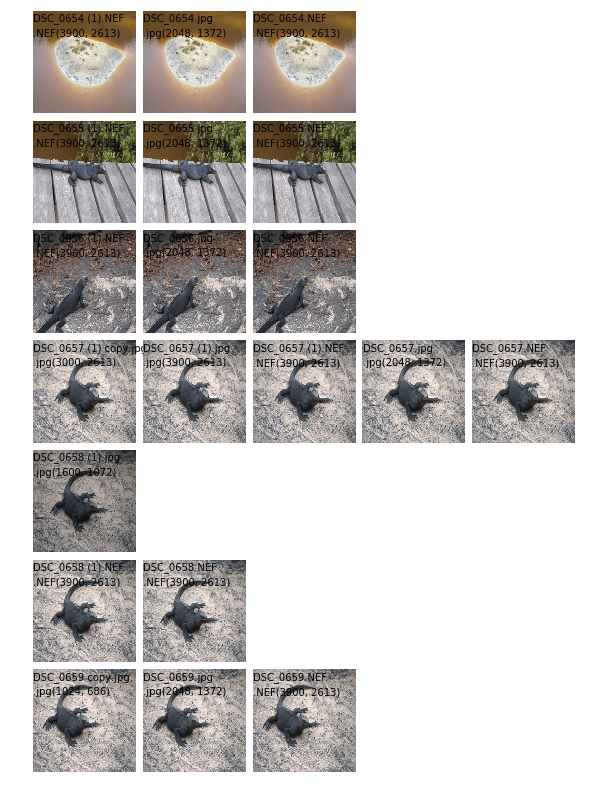

In [10]:
print_index(indx.values())

Well that's not too bad! Notice that the multiple slightly different shots of the iguana are sorted out pretty well (look at the filenames). I'm happy.

Still to do:

 * Working out which of the duplicates to delete
 * Integration with apple photos
 * Deleting them
 * Speeding it up.